## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## 1. Compute the camera calibration matrix and distortion coefficients

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
from moviepy.editor import *
from datetime import datetime

# %matplotlib qt
%matplotlib inline

In [2]:
def draw_plt(img):
#     result = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)    
    plt.show()

In [3]:
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undimage = cv2.undistort(img, mtx, dist, None, mtx)
    return undimage

In [4]:
def perspective(img):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

In [5]:
# def undistort_and_prespective(img):
#     img_size = (img.shape[1], img.shape[0])
#     ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
#     undimage = cv2.undistort(img, mtx, dist, None, mtx)
    
#     M = cv2.getPerspectiveTransform(src, dst)
#     warped = cv2.warpPerspective(undimage, M, img_size)
#     return undimage, warped

In [6]:
def draw(origin, result, origin_camp=None, result_camp=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(origin, cmap=origin_camp)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(result, cmap=result_camp)
    ax2.set_title('Result Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
def cv2_write(fname, img):
    cv2.imwrite(fname, img)
    cv2.imshow('img',img)
    cv2.waitKey(500)

In [38]:
# def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), s_thresh=(170, 255)):
def mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 100), s_thresh=(160, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)[:,:,2]
    v_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)[:,:,2]
    hlsv_binary = np.zeros_like(s_channel)
    hlsv_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (v_channel >= s_thresh[0]) & (v_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(sbinary), sbinary, hlsv_binary)) * 255
    combined_binary = np.zeros_like(sbinary)
    combined_binary[(sbinary == 1) | (hlsv_binary == 1)] = 255
    return color_binary, combined_binary

In [9]:
def get_line_fits(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return out_img, left_lane_inds, right_lane_inds, left_fit, right_fit, nonzerox, nonzeroy, ploty, left_fitx, right_fitx

In [10]:
# Visualization
def draw_line_fits(binary_warped, out_img, left_lane_inds, right_lane_inds, left_fit, right_fit, 
                   nonzerox, nonzeroy, ploty, left_fitx, right_fitx):


    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [11]:
def get_bold_lines(binary_warped,left_lane_inds,right_lane_inds, left_fitx, right_fitx, ploty, nonzerox, nonzeroy):
    margin = 100
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    return window_img, out_img, left_line_pts, right_line_pts

In [12]:
def draw_bold_lines(window_img, out_img, left_line_pts, right_line_pts, left_fitx, right_fitx, ploty):
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [13]:
def back_to_oimg(warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = cv2.getPerspectiveTransform(dst,src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [14]:
def get_curve(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    mid_curverad = (left_curverad + right_curverad)/2
    return left_curverad, right_curverad, mid_curverad

In [15]:
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

In [16]:
# src_pts = np.array([[210,720],[555,480],[735,480],[1110,720]], np.int32)
# src_pts = np.array([[210,720],[580,460],[705,460],[1110,720]], np.int32)
# src_pts = np.array([[280,670],[580,460],[705,460],[1030,670]], np.int32)
src_pts = np.array([[280,670],[580,460],[700,460],[1000,670]], np.int32)
# dst_pts = np.array([[300,720],[300,0],[980,0],[980,720]], np.int32)
dst_pts = np.array([[300,720],[300,0],[980,0],[980,720]], np.int32)

src = np.float32(src_pts)
dst = np.float32(dst_pts)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

### find Chessboard Corners

In [44]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

images = glob.glob('./camera_cal/calibration*.jpg')

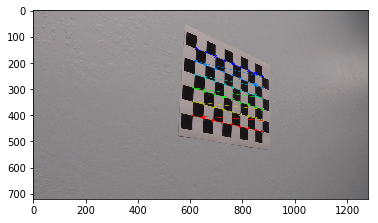

In [45]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        corner_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        cv2_write('./output_images/camera_cal/corners/'+os.path.basename(fname),corner_img)

cv2.destroyAllWindows()
pickle.dump( {'objpoints':objpoints, 'imgpoints':imgpoints}, open( "wide_dist_pickle.p", "wb" ))

# draw(img, corner_img)
plt.imshow(corner_img)
plt.show()

## 2. Apply a distortion correction to raw images.

In [39]:
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

In [40]:
# distortion and perspective
def undistort_and_prespective_corners(origin_fname):   #, result_fname):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    offset = (img_size[0]/10, img_size[1]/10)      # offset for dst points
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undimage = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undimage, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    warped = None
    # if corners found: 
    if ret == True: 
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset[0], offset[1]], [img_size[0]-offset[0], offset[1]], 
                                             [img_size[0]-offset[0], img_size[1]-offset[1]], 
                                             [offset[0], img_size[1]-offset[1]]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undimage, M, img_size)
        
    return img, warped


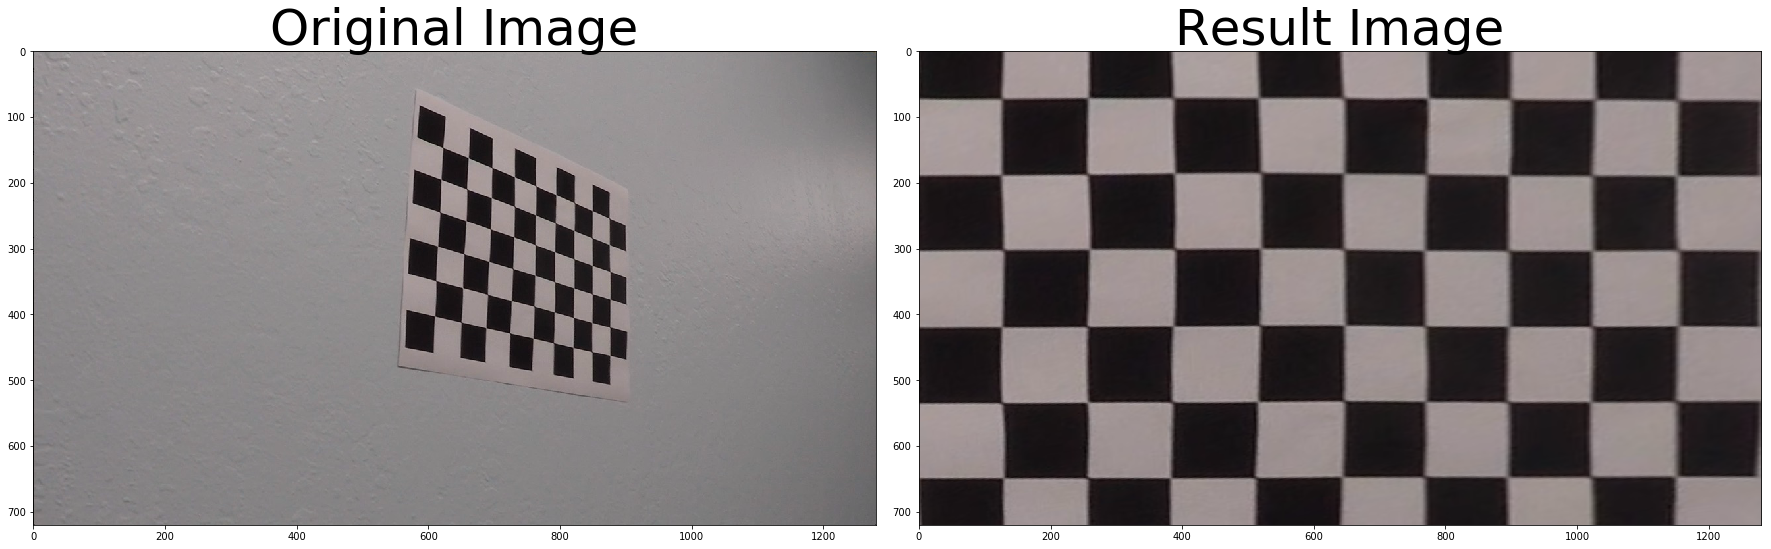

In [44]:
for fname in images:
    img, warped = undistort_and_prespective_corners(fname) #, './output_images/camera_cal/perspectives/'+os.path.basename(fname))
    if warped is not None:
        cv2_write('./output_images/camera_cal/perspectives/'+os.path.basename(fname), warped)
        
cv2.destroyAllWindows()
draw(img, warped)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [34]:
test_images =  glob.glob('./test_images/*.jpg')

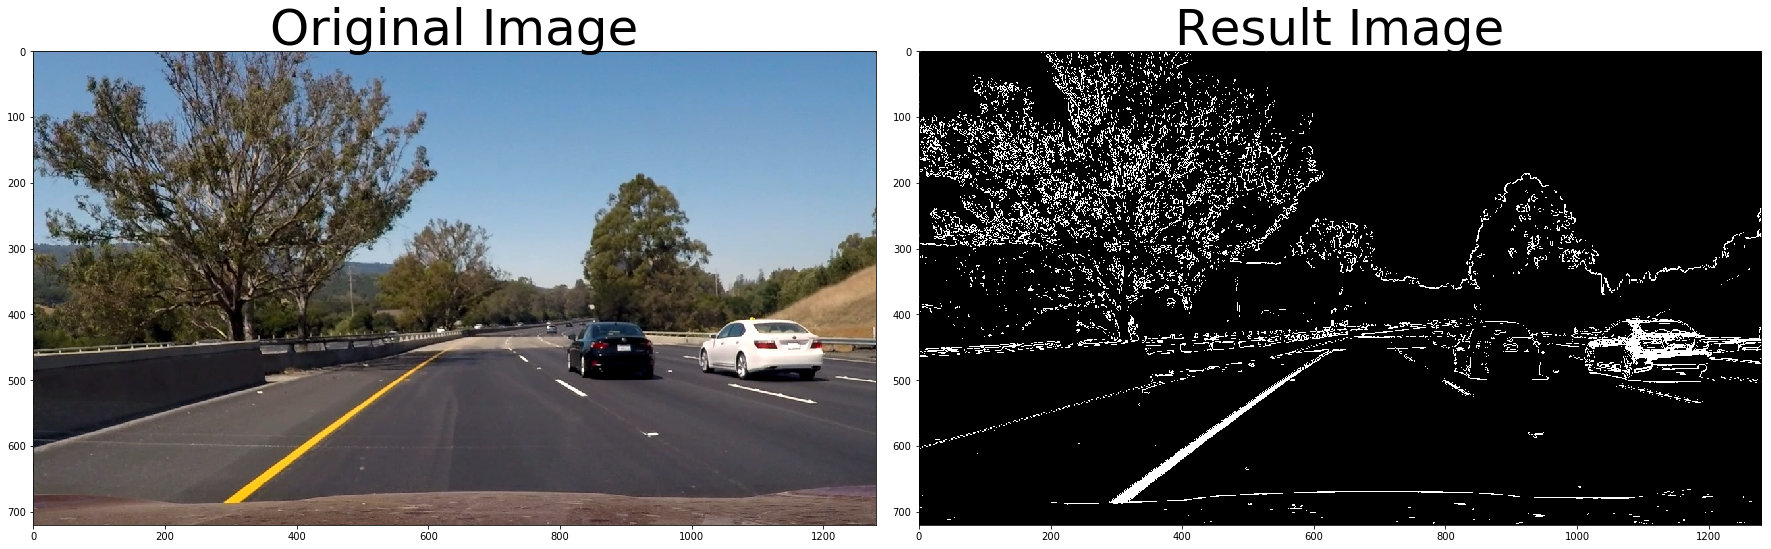

In [39]:
for fname in test_images:
    test_image = mpimg.imread(fname)
    color_binary, mag_binary = mag_thresh(test_image)    # , sobel_kernel=3, mag_thresh=(50, 150))
    cv2_write('./output_images/test_images/color_thresh/'+os.path.basename(fname),color_binary)
    cv2_write('./output_images/test_images/mag_thresh/'+os.path.basename(fname),mag_binary)
        
cv2.destroyAllWindows()
draw(test_image, mag_binary, None, 'gray')

## 3.Apply a perspective transform to rectify binary image ("birds-eye view").

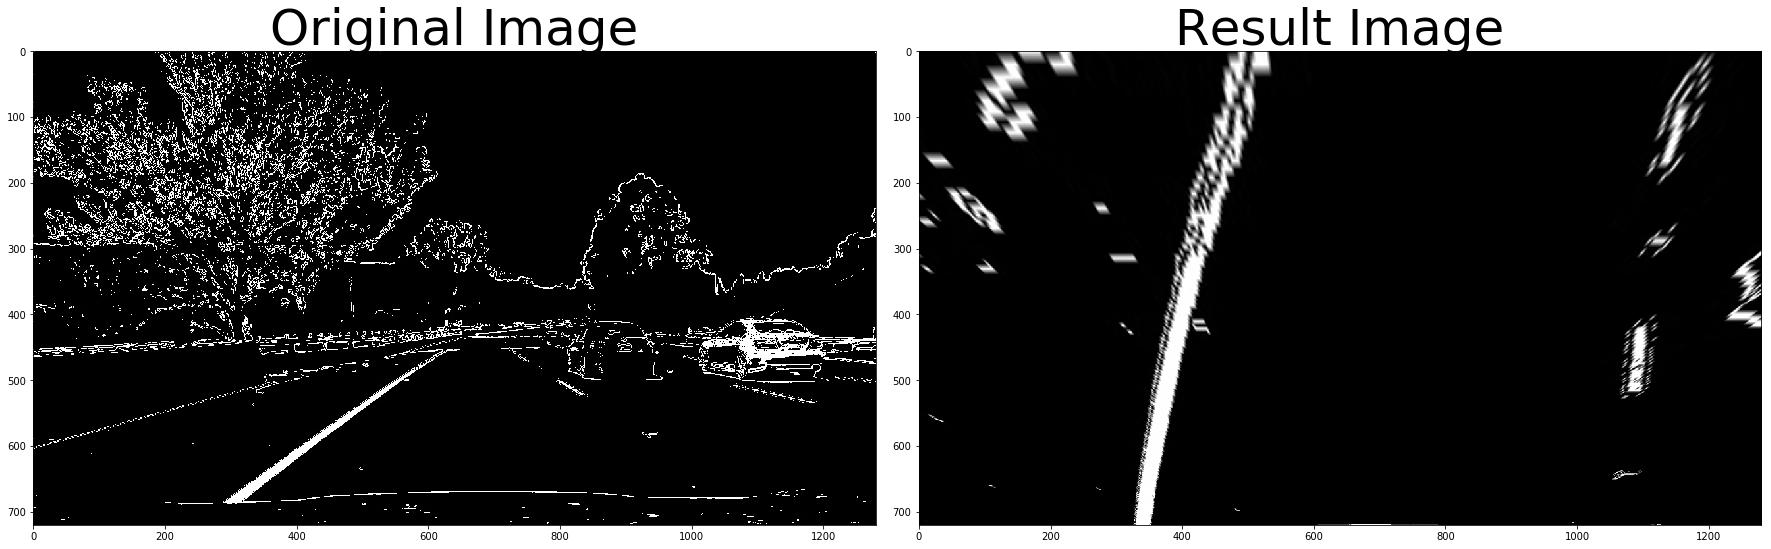

In [40]:
binary_imgs = glob.glob('./output_images/test_images/mag_thresh/*.jpg')
for fname in binary_imgs:
    binary_img = cv2.imread(fname)
    bird_img = perspective(binary_img)
    cv2_write('./output_images/test_images/bird_views/'+os.path.basename(fname),bird_img)
        
cv2.destroyAllWindows()
draw(binary_img, bird_img, 'gray', 'gray')

## Detect lane pixels and fit to find the lane boundary.

In [375]:
binary_warped = cv2.imread('./output_images/test_images/bird_views/test6.jpg', 0)
# binary_warped = np.array(binary_warped)
print('binary_warped:')
print(binary_warped.shape)


binary_warped:
(720, 1280)


In [378]:
# Skip the sliding windows step once you know where the lines are

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

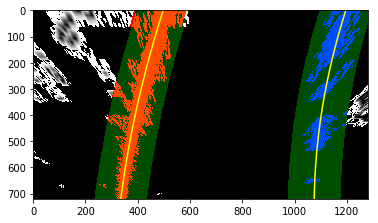

In [379]:


# # Draw the lane onto the warped blank image
# cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

## Warp the detected lane boundaries back onto the original image.

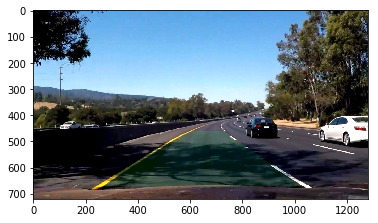

In [41]:
undist = cv2.imread('./test_images/my2test.jpg')
warped = cv2.imread('./output_images/test_images/bird_views/my2test.jpg', 0)

out_img, left_lane_inds, right_lane_inds, left_fit, right_fit, \
nonzerox, nonzeroy, ploty, left_fitx, right_fitx \
= get_line_fits(warped)

newwarp = back_to_oimg(warped, undist, left_fitx, right_fitx, ploty)

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
result_plt = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
plt.imshow(result_plt)
plt.show()






## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [26]:
# def find_line(fname):
def find_line(o_img):
    undist = undistort(o_img)
    
    color_binary, mag_binary = mag_thresh(o_img)
    warped = perspective(mag_binary)
    
    out_img, left_lane_inds, right_lane_inds, left_fit, right_fit, \
    nonzerox, nonzeroy, ploty, left_fitx, right_fitx \
    = get_line_fits(warped)

    newwarp = back_to_oimg(warped, undist, left_fitx, right_fitx, ploty)
    
    left_curve, right_curve, mid_curve = get_curve(left_fitx, right_fitx, ploty)
    cv2.putText(newwarp, 'Radius of Curvature = '+str(round(mid_curve,3))+'(m)',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-newwarp.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff  < 0:
        side_pos = 'right'
    cv2.putText(newwarp, 'Vehicle is  '+str(round(center_diff,3))+'(m) '+side_pos,(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(newwarp, datetime.now().strftime('%H:%M:%S'),(50,150),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    
    out_path = './output_images/videos/' + datetime.now().strftime('%H_%M_%S') + '.jpg'
#     cv2.imwrite(out_path, newwarp)
    
    return newwarp
    

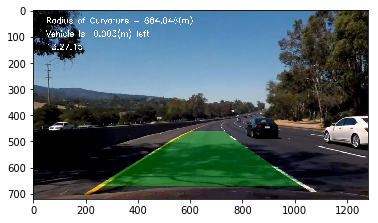

In [42]:
# o_image = cv2.imread('./test_images/test6.jpg')
o_image = cv2.imread('./test_images/my2test.jpg')
result = find_line(o_image)
# cv2.imwrite('./output_images/videos/result.jpg',result)
result_plt = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
draw_plt(result_plt)

In [45]:
input_video = 'project_video.mp4'
output_video = 'output_tracked.mp4'

clips = VideoFileClip(input_video)
# video_clip = clips.fl_image(find_line).subclip(40,43)
video_clip = clips.fl_image(find_line)
video_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video output_tracked.mp4
[MoviePy] Writing video output_tracked.mp4


100%|█████████▉| 1260/1261 [41:53<00:01,  1.78s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_tracked.mp4 

